#Directory, Libraries and Data

In [ ]:
# Mount Google Drive to access files in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the folder
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from prophet import Prophet

In [ ]:
# Load data
# Data of daily visit to the Udemy's Wikipedia
df = pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [ ]:
# Looking into what kind of variables we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


In [ ]:
# Summary statistics of our data
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


<Axes: >

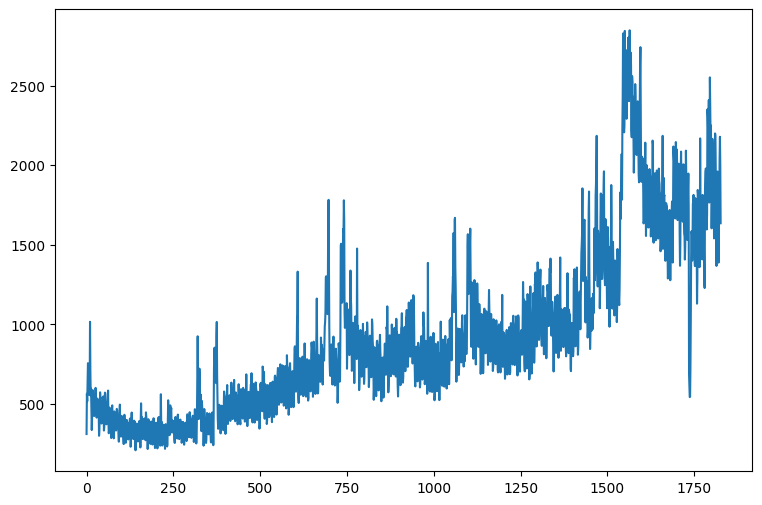

In [ ]:
# Plot the data
df.Udemy.plot(figsize = (9,6))

#Data Preparation

In [ ]:
# Change the type of the column 'Date' into datetime
# Date variable: %m/%d/%Y -> %Y-%m-%d
df.Date = pd.to_datetime(df.Date,
                         format = "%m/%d/%Y")
df.Date

,Date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05
...,...
1822,2020-12-27
1823,2020-12-28
1824,2020-12-29
1825,2020-12-30


In [ ]:
# Rename column 'Date' to 'ds', and 'Udemy' to 'y'
df = df.rename(columns = {'Date': 'ds',
                          'Udemy': 'y'})
df.head(1)

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0


#holidays

In [ ]:
## Easter

# Extract dates where Easter is observed from the DataFrame
easter_dates = df[df.Easter ==1 ].ds
# Create a DataFrame for Easter holidays with a specific window
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5, # Days before Easter to include in the analysis
                       'upper_window': 2}) # Days after Easter to include in the analysis

In [ ]:
## Black Friday

# Extract dates where Black Friday is observed from the DataFrame
bf_dates = pd.to_datetime(df[df['Black Friday'] == 1].ds)
# Create a DataFrame for Black Friday with a specific window
bf = pd.DataFrame({'holiday': 'black_friday',
                   'ds': bf_dates,
                   'lower_window': -7,  # Days before Easter to include in the analysis
                   'upper_window': 5})  # Days after Easter to include in the analysis

In [ ]:
# Combine both DataFrame to create hoidays df
holidays = pd.concat([easter, bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [ ]:
# Remove the holiday columns from the main df
df = df.drop(columns = ["Easter", "Black Friday"])
# The remaining columns
df.head(0)

,ds,y,Christmas


#Prophet Model

In [ ]:
test_days = 31 # Number of days to be used for the test set

# Split the data into training and test sets
training = df.iloc[:-test_days, : ]
test = df.iloc[-test_days:, : ]

print(test.head(1))
print(training.tail(1))

             ds     y  Christmas
1796 2020-12-01  2393          0
             ds     y  Christmas
1795 2020-11-30  2551          0


In [ ]:
# Initialize and configure the Prophet model
m = Prophet(growth='linear',              # Use linear growth trend
            yearly_seasonality=True,      # Enable yearly seasonality component
            weekly_seasonality=True,      # Enable weekly seasonality component
            daily_seasonality=False,      # Disable daily seasonality component
            holidays=holidays,            # Include the holidays data for modeling holidays effects
            seasonality_mode='additive',  # Set seasonality mode to additive
            seasonality_prior_scale=10,   # Set prior scale for seasonality components
            holidays_prior_scale=10,      # Set prior scale for holidays effects
            changepoint_prior_scale=0.05) # Set prior scale for changepoints in the trend

# Add a custom regressor for Christmas with a multiplicative effect
m.add_regressor('Christmas', mode = 'multiplicative')

# Optionally, add more regressors as needed
# m.add_regressor('XXXX')

# Fit the model to the training data
m.fit(training)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/8lxjf6d_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/c3udso13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4262', 'data', 'file=/tmp/tmpiqnsew8o/8lxjf6d_.json', 'init=/tmp/tmpiqnsew8o/c3udso13.json', 'output', 'file=/tmp/tmpiqnsew8o/prophet_modelcr181nsz/prophet_model-20240808110100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:01:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Retrieve and display the coefficients for the custom regressors in the Prophet model
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.327456,-0.327456,-0.327456


#Forecasting

In [ ]:
# Create a dataframe for future predictions
future = m.make_future_dataframe(periods=test_days,  # Number of days to forecast
                                 freq='D')           # Frequency of the forecast (daily)

# Concatenate the future dates with the additional regressor columns from the original dataframe
future = pd.concat([future, df.iloc[:, 2:]],  # Assuming the regressors are in columns from the third onwards
                   axis=1)

# Display the future dataframe
future

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0


In [ ]:
# Generate forecast using the model and future dataframe
forecast = m.predict(future)

# Display the first few rows of the forecast dataframe
forecast.head()

# Print the column names of the forecast dataframe to understand the available fields
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'black_friday',
       'black_friday_lower', 'black_friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


In [ ]:
# Assess the impact of a specific holiday in the forecast
holiday = 'black_friday'

# Filter the forecast dataframe for the specific holiday effect and dates after January 1, 2020
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

In [ ]:
#Retrieve the predictions
predictions = forecast.yhat[-test_days:]

In [ ]:
# Accuracy assessment
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate and print the Mean Absolute Error (MAE)
mae = mean_absolute_error(test.y, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate and print the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.y, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 187.3028102683454
Root Mean Squared Error (RMSE): 238.79838072154143


#Visualization

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


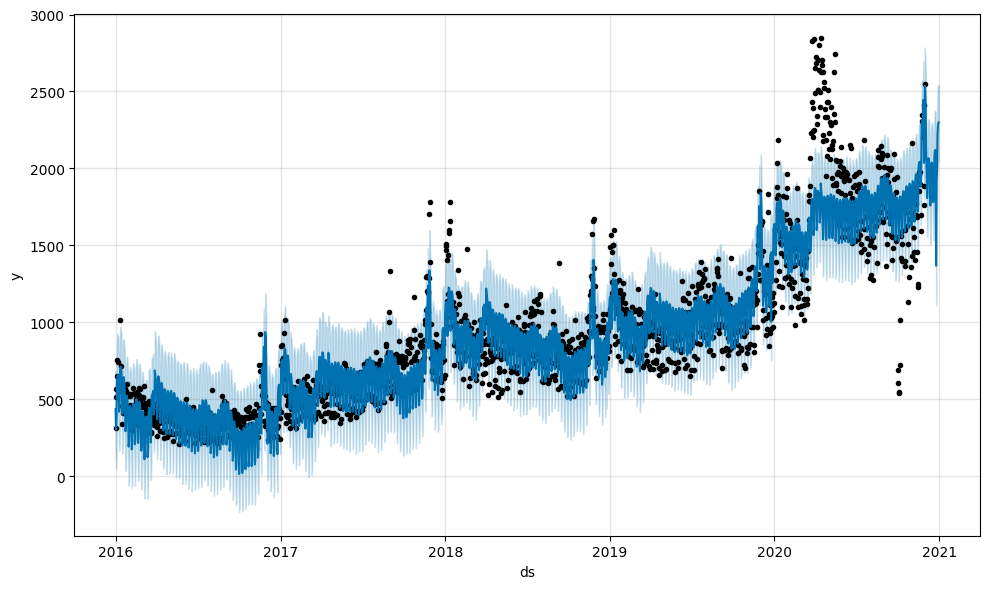

In [ ]:
# Visualize the forecast
m.plot(forecast);

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

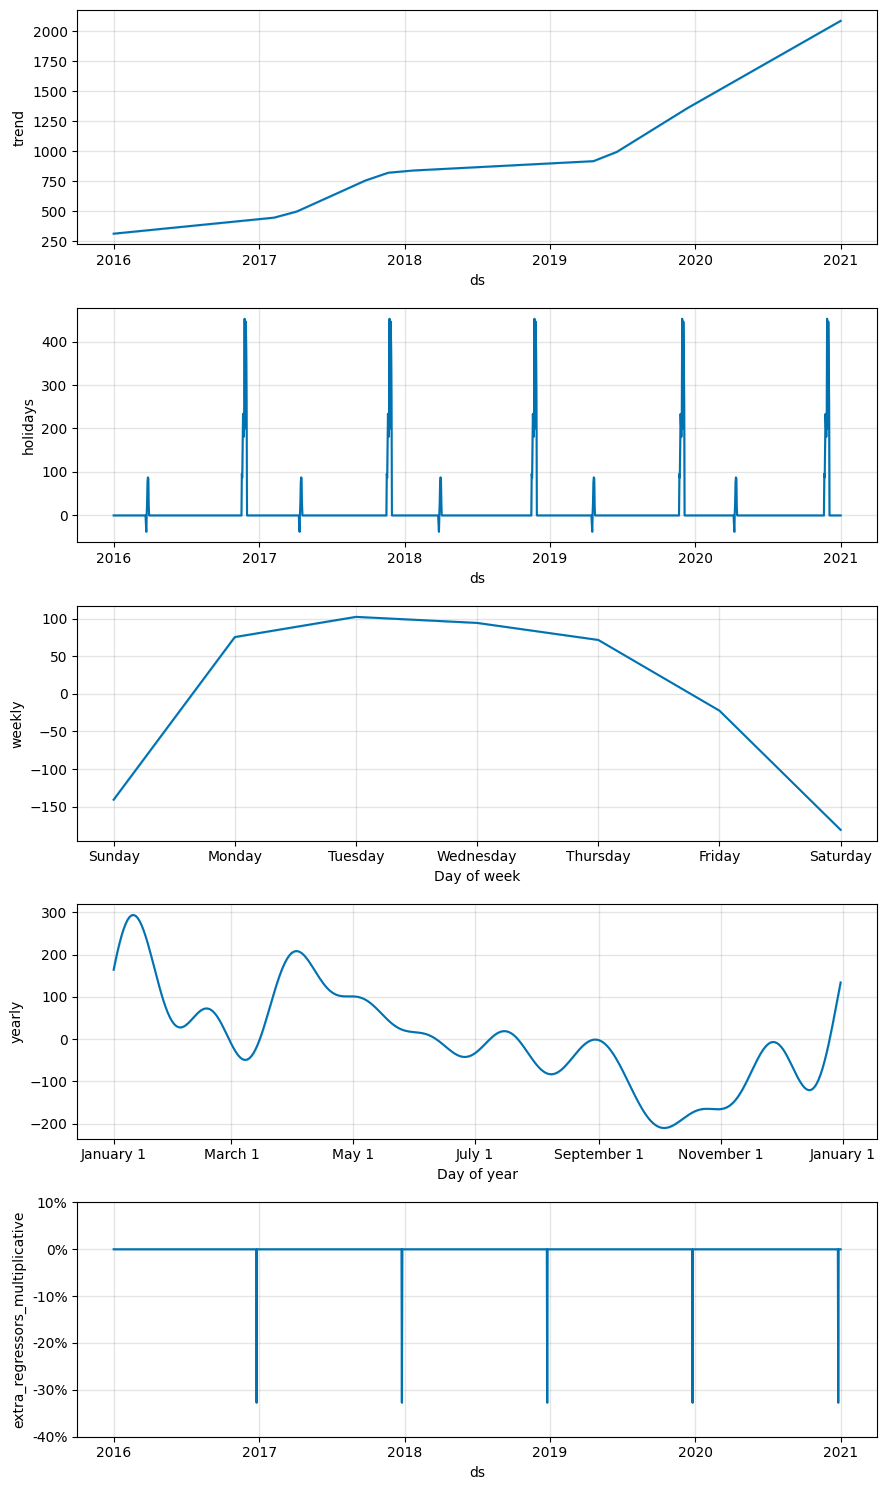

In [ ]:
# Plot the forecast components to visualize the structural time series decomposition
m.plot_components(forecast);

#Cross-Validation

In [ ]:
# Cross-validation for time series model
from prophet.diagnostics import cross_validation

# Perform cross-validation on the Prophet model
df_cv = cross_validation(m,
                         horizon='31 days',      # Forecast horizon (period to predict)
                         initial='1450 days',    # Initial training period
                         parallel='processes')   # Use parallel processing to speed up computation

INFO:prophet:Making 21 forecasts with cutoffs between 2019-12-25 00:00:00 and 2020-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7dee2ec152d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/brzwnlo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/scajlg6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/3ii4t1hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70198', 'data', 'file=/tmp/tmpiqnsew8o/brzwnlo7.json', 'init=/tmp/tmpiqnsew8o/3ii4t1hd.json', 'output', 'file=/tmp/tmpiqnsew8o/prophet_modelhu08d1cc/prophet_model-20240808110107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:01:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/kf36s8wg.json
DE

In [ ]:
# Output of the Cross-Validation
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1282.681827,1142.235616,1415.316382,1165,2019-12-25
1,2019-12-27,1224.100240,1080.908456,1349.973646,1111,2019-12-25
2,2019-12-28,1102.782630,968.819461,1238.311384,1038,2019-12-25
3,2019-12-29,1164.656977,1026.258241,1303.122997,971,2019-12-25
4,2019-12-30,1373.216749,1238.862556,1516.561420,1192,2019-12-25


In [ ]:
# Error assessment

# Calculate and print the Mean Absolute Error (MAE)
print("Mean Absolute Error (MAE):", mean_absolute_error(df_cv['y'], df_cv['yhat']))

# Calculate and print the Root Mean Squared Error (RMSE)
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

Mean Absolute Error (MAE): 399.32610768953765
Root Mean Squared Error (RMSE): 517.55770497542


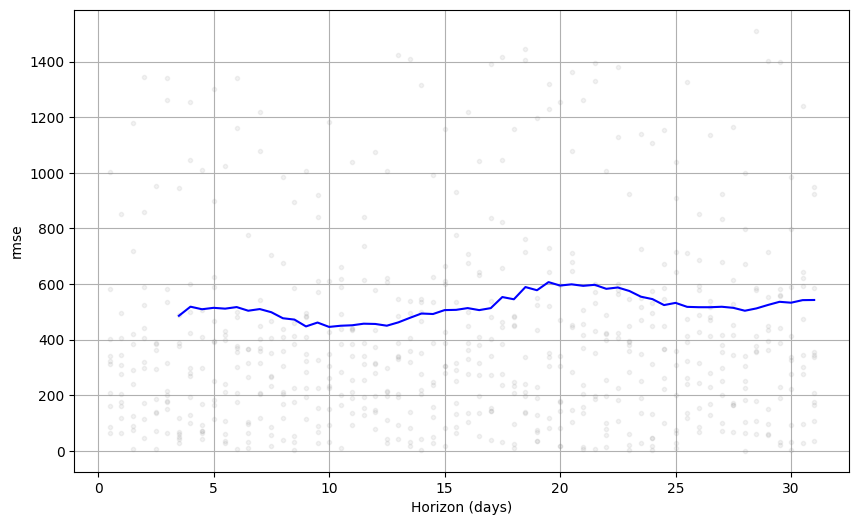

In [ ]:
#CV Visualization
from prophet.plot import plot_cross_validation_metric

# Plot the cross-validation metric (RMSE) for the Prophet model
plot_cross_validation_metric(df_cv,
                             metric = 'rmse'); # Root Mean Squared Error (RMSE) as the metric to visualize

#Parameter tuning

In [ ]:
# Create a grid of parameters for tuning the Prophet model
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for hyperparameter tuning
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}

# Generate all possible combinations of parameters
grid = ParameterGrid(param_grid)

# Output the number of parameter combinations in the grid
len(list(grid))

54

In [ ]:
# Empty list to store RMSE results for each parameter combination
rmse = []

# Start the loop over all parameter combinations
for params in grid:
    # Build and configure the Prophet model with current parameter combination
    m = Prophet(growth='linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays=holidays,
                seasonality_mode=params['seasonality_mode'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                changepoint_prior_scale=params['changepoint_prior_scale'])
    m.add_regressor('Christmas', mode='multiplicative')

    # Fit the model to the training data
    m.fit(training)

    # Perform cross-validation
    df_cv = cross_validation(m,
                             horizon='31 days',   # Forecast horizon for cross-validation
                             initial='1450 days', # Initial training period
                             parallel='processes')  # Use parallel processing

    # Measure the performance (RMSE) and store the result
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    rmse.append(error)

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/4l_10_3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqnsew8o/3u53p2l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11150', 'data', 'file=/tmp/tmpiqnsew8o/4l_10_3o.json', 'init=/tmp/tmpiqnsew8o/3u53p2l6.json', 'output', 'file=/tmp/tmpiqnsew8o/prophet_modelfrlpwrrq/prophet_model-20240808110944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 21 forecasts with cutoffs between 2019-12-25 00:00:00 and 2020-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object

In [ ]:
# Convert the grid of parameters and corresponding RMSE results into a DataFrame
tuning_results = pd.DataFrame(grid)

# Add the RMSE results to the DataFrame
tuning_results['rmse'] = rmse

# Display the DataFrame with parameter combinations and their associated RMSE
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,512.109627
1,0.01,5,additive,10,513.047127
2,0.01,5,additive,20,511.581045
3,0.01,5,multiplicative,5,528.123101
4,0.01,5,multiplicative,10,533.398678
5,0.01,5,multiplicative,20,531.076191
6,0.01,10,additive,5,510.809080
7,0.01,10,additive,10,511.420321
8,0.01,10,additive,20,509.607141
9,0.01,10,multiplicative,5,529.235154
